In [18]:
!pip install --user PyROQ==0.1.25

  Found existing installation: PyROQ 0.1.24
    Uninstalling PyROQ-0.1.24:
      Successfully uninstalled PyROQ-0.1.24


In [1]:
import numpy
import numpy as np
import scipy
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import lal
import lalsimulation
from lal.lal import PC_SI as LAL_PC_SI
import h5py
import warnings
import random
warnings.filterwarnings('ignore')
import matplotlib.pylab as pylab
plot_params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(plot_params)
from mpl_toolkits.mplot3d import axes3d
import PyROQ.pyroq as pyroq
#import pyroq as pyroq

# Setting up boundary conditions and tolerance requirements.

In [2]:
mc_low = 20
mc_high = 30
q_low = 1
q_high = 2
s1sphere_low = [0, 0, 0]
s1sphere_high = [0.2, numpy.pi, 2.0*numpy.pi]
s2sphere_low = [0, 0, 0]
s2sphere_high = [0.2, numpy.pi, 2.0*numpy.pi]
ecc_low = 0.0
ecc_high = 0.2
lambda1_low = 0
lambda1_high = 1000
lambda2_low = 0
lambda2_high = 1000
iota_low = 0
iota_high = numpy.pi
phiref_low = 0
phiref_high = 2*numpy.pi
f_min = 20
f_max = 1024
deltaF = 1/4.
distance = 10 * LAL_PC_SI * 1.0e6  # 10 Mpc is default 
waveFlags = lal.CreateDict()

approximant = lalsimulation.IMRPhenomPv2
print("mass-min, mass-max: ", pyroq.massrange(mc_low, mc_high, q_low, q_high))

npts = 100 # Specify the number of points for each search for a new basis element
          # For diagnostic testing, 30 -100 is fine. 
          # For real ROQs computation, this can be 300 to 1000, roughly comparable to the number of basis elments.
          # What value to choose depends on the nature of the waveform, such as how many features it has. 
          # It also depends on the parameter space and the signal length. 
nts = 1000 # Number of random test waveforms
          # For diagnostics, 1000 is fine.
          # For real ROQs calculation, set it to be 1000000.

nbases = 100 # Specify the number of linear basis elements. Put your estimation here for the chunk of parameter space.
ndimlow = 40 # Your estimation of fewest basis elements needed for this chunk of parameter space.
ndimhigh = nbases+1 
ndimstepsize = 10 # Number of linear basis elements increament to check if the basis satisfies the tolerance.
tolerance = 1e-8 # Surrogage error threshold for linear basis elements

nbases_quad = 60 # Specify the number of quadratic basis elements, depending on the tolerance_quad, usually two thirds of that for linear basis
ndimlow_quad = 20
ndimhigh_quad = nbases_quad+1
ndimstepsize_quad = 10
tolerance_quad = 1e-10 # Surrogage error threshold for quadratic basis elements

mass-min, mass-max:  [16.437518295172257, 49.31255488551677]


In [3]:
freq = numpy.arange(f_min,f_max,deltaF)
nparams, params_low, params_high, params_start, hp1 = pyroq.initial_basis(mc_low, mc_high, q_low, q_high, s1sphere_low, s1sphere_high, \
                  s2sphere_low, s2sphere_high, ecc_low, ecc_high, lambda1_low, lambda1_high,\
                 lambda2_low, lambda2_high, iota_low, iota_high, phiref_low, phiref_high, distance, deltaF, f_min, f_max, waveFlags, approximant)


In [4]:
mmin=pyroq.get_m1m2_from_mcq(10,4)
print(mmin)

[24.02248868  6.00562217]


In [5]:
print(nparams)
print(len(freq))

10
4016


# Search for linear basis elements to build and save linear ROQ data in the local directory.

In [6]:
known_bases_start = numpy.array([hp1/numpy.sqrt(numpy.vdot(hp1,hp1))])
basis_waveforms_start = numpy.array([hp1])
residual_modula_start = numpy.array([0.0])
known_bases, params, residual_modula = pyroq.bases_searching_results_unnormalized(npts, nparams, nbases, known_bases_start, basis_waveforms_start, params_start, residual_modula_start, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)
print(known_bases.shape, residual_modula)


The parameters are Mc, q, s1(mag, theta, phi), s2(mag, theta, phi), iota, and phiRef

Linear Iter:  0 [2.9160514e+01 1.1201620e+00 3.6590000e-02 3.7501200e-01 7.7774200e-01
 1.9286000e-01 2.2214360e+00 5.8542200e+00 1.4840000e-02 2.9872610e+00]
Linear Iter:  1 [28.158356  1.892391  0.168593  2.099998  2.98323   0.058009  1.097216
  4.923935  2.859613  2.38755 ]
Linear Iter:  2 [20.116899  1.743618  0.070692  0.579802  2.489543  0.063308  1.902808
  2.011588  3.052893  2.333674]
Linear Iter:  3 [2.7925118e+01 1.0091980e+00 2.5518000e-02 1.1042480e+00 7.7885000e-01
 1.5834300e-01 1.1908630e+00 5.1052150e+00 3.0675330e+00 1.4240270e+00]
Linear Iter:  4 [28.106905  1.16684   0.047885  0.967842  0.0388    0.169504  1.098119
  2.150809  2.691675  6.032498]
Linear Iter:  5 [25.341802  1.856885  0.054191  0.97375   5.201505  0.129822  1.847502
  5.499063  3.086929  3.318931]
Linear Iter:  6 [26.293059  1.012835  0.09784   0.658611  0.050196  0.127395  0.931097
  2.099377  0.135     0.582112]
L

In [7]:
pyroq.roqs(tolerance, freq, ndimlow, ndimhigh, ndimstepsize, known_bases, nts, nparams, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)


40 basis elements gave 159 bad points of surrogate error >  1e-08
50 basis elements gave 7 bad points of surrogate error >  1e-08
60 basis elements gave 2 bad points of surrogate error >  1e-08
70 basis elements gave 0 bad points of surrogate error >  1e-08
Number of linear basis elements is  70 and the linear ROQ data are saved in B_linear.npy


In [8]:
fnodes_linear = numpy.load('./fnodes_linear.npy')
b_linear = numpy.transpose(numpy.load('./B_linear.npy'))
ndim = b_linear.shape[1]
freq = numpy.arange(f_min, f_max, deltaF)
emp_nodes = numpy.searchsorted(freq, fnodes_linear)
print(b_linear)
print("emp_nodes", emp_nodes)

[[ 1.00000000e+00+1.81898940e-11j -8.73114914e-11-5.82076609e-11j
   1.30967237e-10-4.36557457e-11j ... -1.45519152e-10-1.52795110e-10j
   2.03726813e-10+2.83762347e-10j -5.82076609e-10-4.22005542e-10j]
 [-3.63797881e-12-5.45696821e-12j  1.00000000e+00-1.45519152e-11j
   0.00000000e+00+2.18278728e-11j ... -3.63797881e-11-2.91038305e-11j
  -1.81898940e-11-1.74622983e-10j  7.27595761e-11+0.00000000e+00j]
 [ 1.81898940e-12+5.45696821e-12j -1.45519152e-11+2.18278728e-11j
   1.00000000e+00+2.91038305e-11j ... -1.16415322e-10-5.09317033e-11j
  -1.16415322e-10+6.36646291e-11j -2.91038305e-10-1.22099664e-10j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+

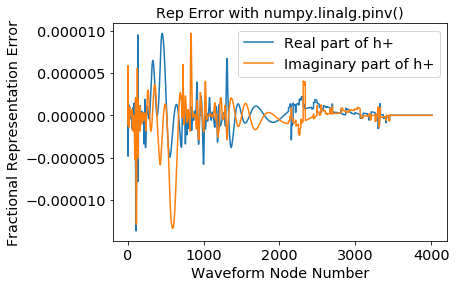

In [9]:
test_mc = 20
test_q = 4
test_s1 = [0.,0.2,-0.]
test_s2 = [0.,0.15,-0.1]
test_ecc = 0
test_lambda1 = 0
test_lambda2 = 0
test_iota = 1.9
test_phiref = 0.6

pyroq.testrep(b_linear, emp_nodes, test_mc, test_q, test_s1, test_s2, test_ecc, test_lambda1, test_lambda2, test_iota, test_phiref, distance, deltaF, f_min, f_max, waveFlags, approximant)


In [10]:
nsamples = 1000 # testing nsamples random samples in parameter space to see their representation surrogate errors
surros = pyroq.surros_of_test_samples(nsamples, nparams, params_low, params_high, tolerance, b_linear, emp_nodes, distance, deltaF, f_min, f_max, waveFlags, approximant)
# If a surrogate error is larger than tolerance, it will be reported on the screen.

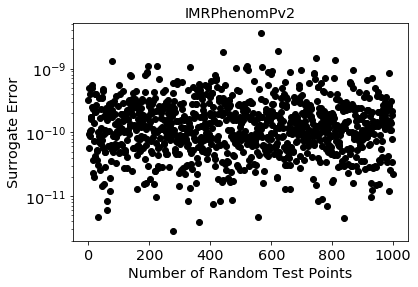

In [11]:
plt.semilogy(surros,'o',color='black')
plt.xlabel("Number of Random Test Points")
plt.ylabel("Surrogate Error")
plt.title("IMRPhenomPv2")
plt.savefig("SurrogateErrorsRandomTestPoints.png")
plt.show()

# Search for quadratic basis elements to build & save quadratic ROQ data.

In [12]:
hp1_quad = (numpy.absolute(hp1))**2
known_quad_bases_start = numpy.array([hp1_quad/numpy.sqrt(numpy.vdot(hp1_quad,hp1_quad))])
basis_waveforms_quad_start = numpy.array([hp1_quad])
residual_modula_start = numpy.array([0.0])
known_quad_bases,params_quad,residual_modula_quad = pyroq.bases_searching_quadratic_results_unnormalized(npts, nparams, nbases_quad, known_quad_bases_start, basis_waveforms_quad_start, params_start, residual_modula_start, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)
known_quad_bases_copy = known_quad_bases


Quadratic Iter:  0
Quadratic Iter:  1
Quadratic Iter:  2
Quadratic Iter:  3
Quadratic Iter:  4
Quadratic Iter:  5
Quadratic Iter:  6
Quadratic Iter:  7
Quadratic Iter:  8
Quadratic Iter:  9
Quadratic Iter:  10
Quadratic Iter:  11
Quadratic Iter:  12
Quadratic Iter:  13
Quadratic Iter:  14
Quadratic Iter:  15
Quadratic Iter:  16
Quadratic Iter:  17
Quadratic Iter:  18
Quadratic Iter:  19
Quadratic Iter:  20
Quadratic Iter:  21
Quadratic Iter:  22
Quadratic Iter:  23
Quadratic Iter:  24
Quadratic Iter:  25
Quadratic Iter:  26
Quadratic Iter:  27
Quadratic Iter:  28
Quadratic Iter:  29
Quadratic Iter:  30
Quadratic Iter:  31
Quadratic Iter:  32
Quadratic Iter:  33
Quadratic Iter:  34
Quadratic Iter:  35
Quadratic Iter:  36
Quadratic Iter:  37
Quadratic Iter:  38
Quadratic Iter:  39
Quadratic Iter:  40
Quadratic Iter:  41
Quadratic Iter:  42
Quadratic Iter:  43
Quadratic Iter:  44
Quadratic Iter:  45
Quadratic Iter:  46
Quadratic Iter:  47
Quadratic Iter:  48
Quadratic Iter:  49
Quadratic 

In [13]:
points = numpy.random.uniform(params_low, params_high, size=(npts,nparams))


In [14]:
pyroq.roqs_quad(tolerance_quad, freq, ndimlow_quad, ndimhigh_quad, ndimstepsize_quad, known_quad_bases, nts, nparams, params_low, params_high, distance, deltaF, f_min, f_max, waveFlags, approximant)


20 basis elements gave 883 bad points of surrogate error >  1e-10
30 basis elements gave 166 bad points of surrogate error >  1e-10
40 basis elements gave 1 bad points of surrogate error >  1e-10
50 basis elements gave 0 bad points of surrogate error >  1e-10
Number of quadratic basis elements is  50 and the linear ROQ data save in B_quadratic.npy


In [15]:
fnodes_quad = numpy.load('./fnodes_quadratic.npy')
b_quad = numpy.transpose(numpy.load('./B_quadratic.npy'))
ndim_quad = b_quad.shape[1]
freq = numpy.arange(f_min, f_max, deltaF)
emp_nodes_quad = numpy.searchsorted(freq, fnodes_quad)


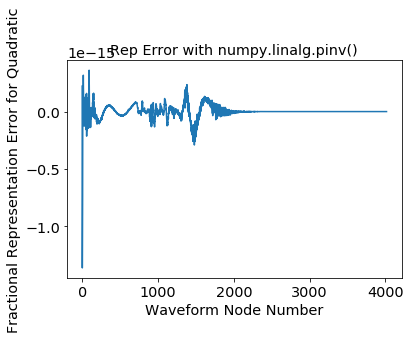

In [16]:
test_mc_quad =20
test_q_quad = 1
test_s1_quad = [0.0, 0.0, 0.0]
test_s2_quad = [0.0, 0.0, 0.0]
test_ecc_quad = 0
test_lambda1_quad = 0
test_lambda2_quad = 0
test_iota_quad = 1.9
test_phiref_quad = 0.6

pyroq.testrep_quad(b_quad, emp_nodes_quad, test_mc_quad, test_q_quad, test_s1_quad, test_s2_quad, test_ecc_quad, test_lambda1_quad, test_lambda2_quad, test_iota_quad, test_phiref_quad, distance, deltaF, f_min, f_max, waveFlags, approximant)
